In [1]:
import numpy as np
from enum import Enum

import matplotlib.pyplot as plt 
%matplotlib notebook

from scipy.ndimage.filters import uniform_filter1d

import nutripy 

In [2]:
CALORIES_STEP_SIZE=250

class Goal(Enum):
    LOSS = -CALORIES_STEP_SIZE
    MAINTAIN = 0
    GAIN = CALORIES_STEP_SIZE

In [3]:
class UnhandledCaseException(Exception):
    pass

In [7]:
nut = nutripy.nutripy.Nutripy()



In [28]:
def is_close(a, b, close=150):
    if abs(a - b) < close:
        return True
    return False

In [5]:
class State:
    pass

class Sequence:
    def __init__(self):
        self.state = {
            "goal": objective,
            "age_in_weeks": 0,
            "phase": Phase.LOSS,
            "dej": dej,
            "mb": mb,
            "aca": aca,
            "weight": 80,
            "weeks_in_phase": 0,
        }
        self.history = deque(maxlen=10)
        
    def get_weight_last_n_weeks(self, n=3):
        if len(self.history) >= n:
            return [x["weight"] for x in self.history][-n:]

In [13]:
class Phase(Enum):
    LOSS = 0
    STOP = 1
    MAINTAINANCE = 2 
    GAIN = 3

# Simulation 

In [43]:
"""
Model of weight variation over one week
        - aca is the real number of calories eaten per day
        - dej is the estimated daily needs in calories
        - sigma represent the randomness, the higher the value, the higher the random 
          variations of the weight
          
          Returns the variation of weight aka weight derivative (NOT the weight) in kilograms
"""

def delta_weight(aca, dej, sigma=.6):
    return np.random.normal(0, sigma) + ((aca - dej) * 7) / 7000 

In [82]:
profile_params = {
    "age": 30, 
    "weight": 50, 
    "height": 1.8, 
    "gender": nutripy.nutripy.Gender.MALE, 
    "activity": nutripy.nutripy.Activity.SEDENTARY, 
    "goal": nutripy.nutripy.Goal.GAIN,
}

sim_params = {
    "profile": profile_params,
    "n_weeks": 100,
    
}

In [83]:
def simulate(sim_params):

    weight_history = []
    aca_history = []
    
    dej_hat = nut.get_daily_needs(**sim_params["profile"])
    aca = dej_hat
    
    weight_history.append(sim_params["profile"]["weight"])
    aca_history.append(aca)
    
    if sim_params["profile"]["goal"] == nutripy.nutripy.Goal.GAIN:
        phases_history = [Phase.GAIN]
    elif sim_params["profile"]["goal"] == nutripy.nutripy.Goal.LOSS:
        phases_history = [Phase.LOSS]
    else:
        raise UnhandledCaseException
        
    for i in range(n_weeks):
        delta_w = delta_weight(aca, dej_hat)
        delta_cal = 0
        
        new_weight = weight_history[-1] + delta_w
        weight_history.append(new_weight)

        current_phase = phases_history[-1]
        duration = 1 # counts the number of weeks within the phase
        
        for i in range(1, len(phases_history)):
            if phases_history[-i-1] == current_phase:
                duration += 1
            else:
                break

        if sim_params["profile"]["goal"] == nutripy.nutripy.Goal.GAIN:
            if current_phase == Phase.GAIN and duration <= 16:
                new_phase = Phase.GAIN

            if current_phase == Phase.GAIN and duration > 16:
                new_phase = Phase.STOP
                duration = 1
                
        elif sim_params["profile"]["goal"] == nutripy.nutripy.Goal.LOSS:
            if current_phase == Phase.LOSS and duration <= 16:
                new_phase = Phase.LOSS
    
            if current_phase == Phase.LOSS and duration > 16:
                new_phase = Phase.STOP
                duration = 1
                
        else:
            raise UnhandledCaseException

        if current_phase == Phase.STOP:
            if is_close(dej_hat, aca, close=200):
                new_phase = Phase.MAINTAINANCE
                phases_history.append(new_phase)

                
                
        if new_phase == Phase.MAINTAINANCE:
            if len(weight_history) > 3:
                weight_derivative = np.gradient(weight_history)
                y = uniform_filter1d(weight_derivative, size=3)
                delta_cal = maintain(y[-1])
                
        if sim_params["profile"]["goal"] == nutripy.nutripy.Goal.GAIN:
            if new_phase == Phase.GAIN:
                if len(weight_history) > 3:
                    weight_derivative = np.gradient(weight_history)
                    y = uniform_filter1d(weight_derivative, size=3)
                    delta_cal = gain(y[-1])
            if new_phase == Phase.STOP:
                if duration == 1:
                    params = {k:v for k,v in profile_params.items()}
                    params["weight"] = weight_history[-1]
                    dej_hat = dej_hat = nut.get_daily_needs(**params)

                if not is_close(dej_hat, aca, close=200):
                    delta_cal = -CALORIES_STEP_SIZE
                
        elif sim_params["profile"]["goal"] == nutripy.nutripy.Goal.LOSS:
            if new_phase == Phase.LOSS:
                if len(weight_history) > 3:
                    weight_derivative = np.gradient(weight_history)
                    y = uniform_filter1d(weight_derivative, size=3)
                    delta_cal = loss(y[-1])
            if new_phase == Phase.STOP:
                if duration == 1:
                        params = {k:v for k,v in profile_params.items()}
                        params["weight"] = weight_history[-1]
                        dej_hat = dej_hat = nut.get_daily_needs(**params)

                if not is_close(dej_hat, aca, close=200):
                    delta_cal = CALORIES_STEP_SIZE
        else:
            raise UnhandledCaseException


        phases_history.append(new_phase)
        aca = aca + delta_cal
        aca_history.append(aca)
        
    return weight_history, aca_history, phases_history

In [84]:
weight_history, aca_history, phases_history = simulate(sim_params)

<IPython.core.display.Javascript object>


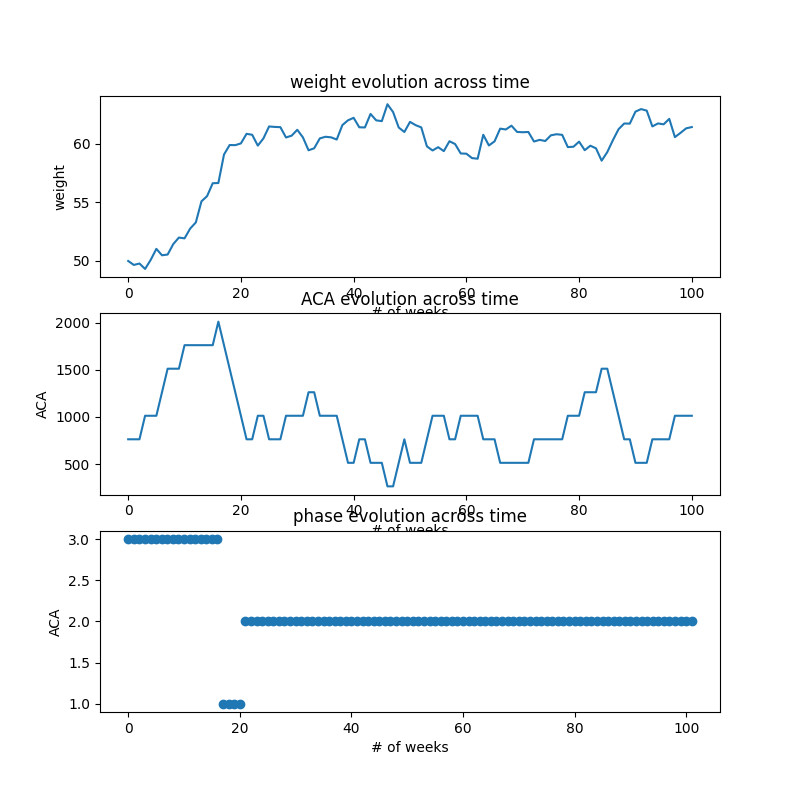

In [85]:
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(311)
ax1.set_ylabel('weight')
ax1.set_xlabel('# of weeks')
ax1.set_title('weight evolution across time')
ax1.plot(weight_history)


ax2 = fig.add_subplot(312)
ax2.set_ylabel('ACA')
ax2.set_xlabel('# of weeks')
ax2.set_title('ACA evolution across time')
ax2.plot(aca_history)

ax3 = fig.add_subplot(313)
ax3.set_ylabel('ACA')
ax3.set_xlabel('# of weeks')
ax3.set_title('phase evolution across time')
ax3.scatter(range(len(phases_history)), [x.value for x in phases_history]) 

plt.show()

## Build muscle

In [45]:
def gain(x):
    if x > 0.5: 
        return 0
    if x <= 0.5:
        return CALORIES_STEP_SIZE

def maintain(x):
    if x > -0.5 and x < 0.5: 
        return 0
    if x > 0.5:
        return -CALORIES_STEP_SIZE
    if x < 0.5:
        return CALORIES_STEP_SIZE

In [46]:
weight_history = []
aca_history = []

weight_history.append(sim_params["weight"])
aca_history.append(aca)
phases_history = [Phase.GAIN]

for i in range(n_weeks):
    delta_w = delta_weight(aca, dej_hat)
    delta_cal = 0
    new_weight = weight_history[-1] + delta_w
    weight_history.append(new_weight)
    
    
    current_phase = phases_history[-1]
    duration = 1
    for i in range(0, len(phases_history)):
        if phases_history[-i-1] == current_phase:
            duration += 1
        else:
            break
            
    #print(duration)
    
    if current_phase == Phase.GAIN and duration <= 16:
        new_phase = Phase.GAIN
        
    
    if current_phase == Phase.GAIN and duration > 16:
        new_phase = Phase.STOP
        duration = 1
        
    if current_phase == Phase.STOP:
        if is_close(dej_hat, aca, close=200):
            new_phase = Phase.MAINTAINANCE
            phases_history.append(new_phase)
         
    if new_phase == Phase.MAINTAINANCE:
        if len(weight_history) > 3:
            weight_derivative = np.gradient(weight_history)
            y = uniform_filter1d(weight_derivative, size=3)
            delta_cal = maintain(y[-1])
    
    if new_phase == Phase.GAIN:
        if len(weight_history) > 3:
            weight_derivative = np.gradient(weight_history)
            y = uniform_filter1d(weight_derivative, size=3)
            delta_cal = gain(y[-1])
    
    if new_phase == Phase.STOP:
        if duration == 1:
            params = {k:v for k,v in profile_params.items()}
            params["weight"] = weight_history[-1]
            dej_hat = dej_hat = nut.get_daily_needs(**params)

        #print(dej_hat)
        if not is_close(dej_hat, aca, close=200):
            delta_cal = -CALORIES_STEP_SIZE
    
    phases_history.append(new_phase)
    aca = aca + delta_cal
    aca_history.append(aca)
    
#    print(aca)

<IPython.core.display.Javascript object>


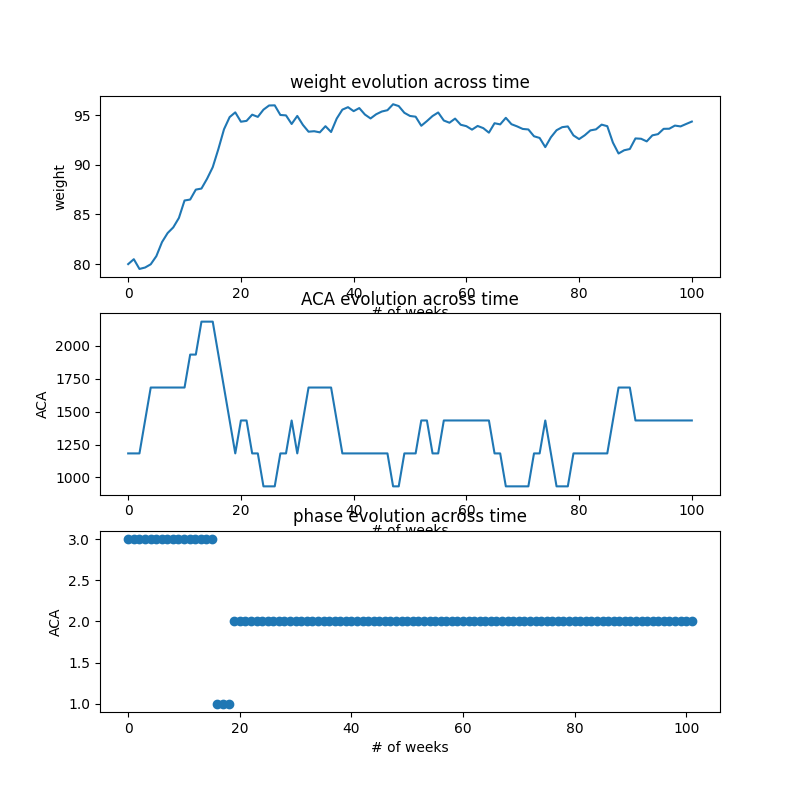

In [47]:
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(311)
ax1.set_ylabel('weight')
ax1.set_xlabel('# of weeks')
ax1.set_title('weight evolution across time')
ax1.plot(weight_history)


ax2 = fig.add_subplot(312)
ax2.set_ylabel('ACA')
ax2.set_xlabel('# of weeks')
ax2.set_title('ACA evolution across time')
ax2.plot(aca_history)

ax3 = fig.add_subplot(313)
ax3.set_ylabel('ACA')
ax3.set_xlabel('# of weeks')
ax3.set_title('phase evolution across time')
ax3.scatter(range(len(phases_history)), [x.value for x in phases_history]) 

plt.show()

## Lose Fat

In [48]:
def loss(x):
    if x < -0.5: 
        return 0
    if x > -0.5:
        return -CALORIES_STEP_SIZE

In [49]:
weight_history = []
aca_history = []

weight_history.append(sim_params["weight"])
aca_history.append(aca)
phases_history = [Phase.LOSS]

for i in range(n_weeks):
    delta_w = delta_weight(aca, dej_hat)
    delta_cal = 0
    new_weight = weight_history[-1] + delta_w
    weight_history.append(new_weight)
    
    
    current_phase = phases_history[-1]
    duration = 1
    for i in range(0, len(phases_history)):
        if phases_history[-i-1] == current_phase:
            duration += 1
        else:
            break
            
    #print(duration)
    
    if current_phase == Phase.LOSS and duration <= 16:
        new_phase = Phase.LOSS
        
    
    if current_phase == Phase.LOSS and duration > 16:
        new_phase = Phase.STOP
        duration = 1
        
    if current_phase == Phase.STOP:
        if is_close(dej_hat, aca, close=200):
            new_phase = Phase.MAINTAINANCE
            phases_history.append(new_phase)
         
    if new_phase == Phase.MAINTAINANCE:
        if len(weight_history) > 3:
            weight_derivative = np.gradient(weight_history)
            y = uniform_filter1d(weight_derivative, size=3)
            delta_cal = maintain(y[-1])
    
    if new_phase == Phase.LOSS:
        if len(weight_history) > 3:
            weight_derivative = np.gradient(weight_history)
            y = uniform_filter1d(weight_derivative, size=3)
            delta_cal = loss(y[-1])
    
    if new_phase == Phase.STOP:
        if duration == 1:
            params = {k:v for k,v in profile_params.items()}
            params["weight"] = weight_history[-1]
            dej_hat = dej_hat = nut.get_daily_needs(**params)

        #print(dej_hat)
        if not is_close(dej_hat, aca, close=200):
            delta_cal = +CALORIES_STEP_SIZE
    
    phases_history.append(new_phase)
    aca = aca + delta_cal
    aca_history.append(aca)
    
#    print(aca)

<IPython.core.display.Javascript object>


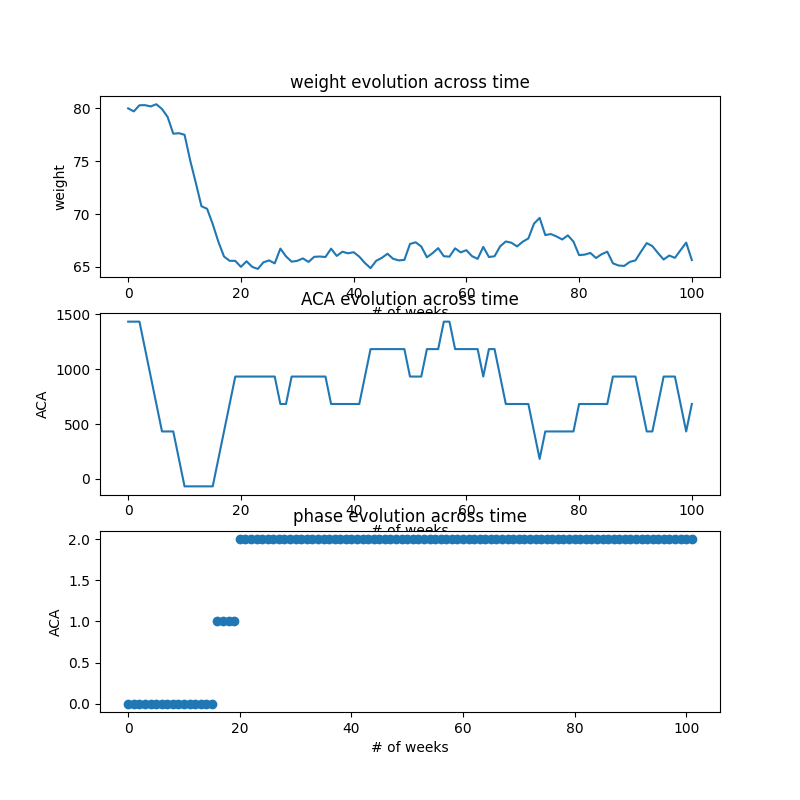

In [50]:
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(311)
ax1.set_ylabel('weight')
ax1.set_xlabel('# of weeks')
ax1.set_title('weight evolution across time')
ax1.plot(weight_history)


ax2 = fig.add_subplot(312)
ax2.set_ylabel('ACA')
ax2.set_xlabel('# of weeks')
ax2.set_title('ACA evolution across time')
ax2.plot(aca_history)

ax3 = fig.add_subplot(313)
ax3.set_ylabel('ACA')
ax3.set_xlabel('# of weeks')
ax3.set_title('phase evolution across time')
ax3.scatter(range(len(phases_history)), [x.value for x in phases_history]) 

plt.show()